In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import utils
import importlib
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.ticker as plticker
importlib.reload(utils)
import datetime as dt
import numpy as np
import warnings

import pandas as pd
from pandas.errors import SettingWithCopyWarning
# from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

/home/jptalusan/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(



* load logs
* pick trips/events
* x-axis are time
* y-axis # of passengers picked up
* text on top of line is explanation or overload bus id

In [2]:
def merge_all_indices(valid_df, all_indices):
    dt_indices = np.unique(np.asarray(all_indices))
    dt_indices = pd.to_datetime(dt_indices) 
    valid_df = valid_df.set_index('actual_time')
    a = pd.DataFrame(index=dt_indices)
    all_indices = valid_df.join(a, how='right').fillna(0)
    return all_indices
# SUBPLOTS
# pick a trip where mcts dispatched to but not the baseline
log_files = ['MCTS_RESULTS/2022_NEW_C/no_inject_20221010_200IT_10CAP.log',
             'MCTS_RESULTS/10_2022_BL/no_inject_BL_20221010_0IT_10CAP.log']
df_arr = {}
labels = ["mcts", "bl"]
for i, log_file in enumerate(log_files):
    df = utils.get_bus_df(log_file)
    dispatch_df = utils.get_dispatch_df(log_file)
    df_arr[labels[i]] = [df, dispatch_df]

In [3]:
# import re
# a = '[info] [2022-10-10 05:07:22] Bus 41 on trip: 279128 scheduled for 2022-10-10 05:07:00 arrives at @ MCC4_15: got_on:0, on:0, offs:0, remain:0, bus_load:0'
# stop_id = re.search(r"@ (.*): got_on", a).group(1)
# bus_id = re.search(r"Bus (4\d{1})", a)
# bus_id.group(1)

In [75]:
import re
import ast, json

DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'

def get_bus_df(log_file):
    # bus stats
    bus_stats = []
    # stop_id = None
    bus_stop = {}
    # found = False
    with open(log_file) as file:
        for line in file:
            entry = None
            
            bus_id = re.search(r"Bus (4\d{1})", line)
            if bus_id:
                if re.search(r"@ (.*): got_on", line):
                    stop_id = re.search(r"@ (.*): got_on", line).group(1)
                    bus_id = int(bus_id.group(1))
                    bus_stop[bus_id] = stop_id
                    found = True

            if "ActionType.OVERLOAD_ALLOCATE: 'overload_allocate'" in line:
                data = line.rstrip()
                in_brackets = re.findall("\[(.*?)\]", data)
                out_brackets = re.findall(r"(.*?)(?:\[.*?\]|$)", data)
                log_text = out_brackets[2].strip().split("Chosen action:")[-1]
                
                # [debug] [2022-10-10 13:35:00] Chosen action:{'type': <ActionType.OVERLOAD_ALLOCATE: 'overload_allocate'>, 'overload_bus': '41', 'info': 'MCC5_1'}
                bus_id = int(log_text.split("'overload_bus': ")[1].split(",")[0].replace("'", ""))
                dest_stop = log_text.split("'info': ")[1].split(",")[0][:-1].replace("'", "")
                time = dt.datetime.strptime(in_brackets[1], DATETIME_FORMAT)
                entry = {"actual_time":time,
                        "bus_id":bus_id,
                        "source_stop":bus_stop.get(bus_id),
                        "dest_stop":dest_stop,
                        "action":"allocate"}
                bus_stop[bus_id] = dest_stop
                
            if "Dispatching overflow bus" in line:
                data = line.rstrip()
                in_brackets = re.findall("\[(.*?)\]", data)
                out_brackets = re.findall(r"(.*?)(?:\[.*?\]|$)", data)
                log_text = out_brackets[2].strip().split(" ")
                bus_id = int(log_text[3])
                source_stop = log_text[5]
                dest_stop = log_text[8]
                time = dt.datetime.strptime(in_brackets[1], DATETIME_FORMAT)
                # print(time, bus_id, source_stop, dest_stop)
                entry = {"actual_time":time,
                        "bus_id":bus_id,
                        "source_stop":source_stop,
                        "dest_stop":dest_stop,
                        "action":"dispatch"}
            if entry:
                bus_stats.append(entry)
    bus_stats = pd.DataFrame(bus_stats)
    return bus_stats
    
df = get_bus_df('MCTS_RESULTS/2022_NEW_C/no_inject_20221009_200IT_10CAP.log')
# df = get_bus_df('MCTS_RESULTS/2022_NEW_C_NOREALLOC/no_inject_20221009_200IT_10CAP_NOREALLOC.log')
# df = get_bus_df('MCTS_RESULTS/10_2022_BL/no_inject_BL_20221010_0IT_10CAP.log')

In [76]:
# Map stuff
import os
import geopandas as gpd

basefolder = os.path.join('..', 'data_generation')
datafolder = os.path.join(basefolder, 'data')
resfolder = os.path.join(basefolder, 'results')

# maps
fp = os.path.join(datafolder, 'shapefiles', "tncounty")
gdf_county = gpd.read_file(fp)
gdf_dav = gdf_county[gdf_county["NAME"] == "Davidson"]
gdf_dav = gdf_dav.to_crs("EPSG:4326")

fp = os.path.join(datafolder, 'inrix_grouped.pkl')
inrix_grouped = pd.read_pickle(fp)
inrix_grouped = inrix_grouped.set_geometry('geometry')
inrix_grouped = inrix_grouped[inrix_grouped.within(gdf_dav.geometry.iloc[0])]

# coords
stops = pd.read_pickle(f"{resfolder}/stops_node_matching_2022.pkl")

# merge for coords
df = df.fillna(value=np.nan)

arr = []
for k, v in df.groupby('bus_id'):
    v = v.reset_index(drop=True)
    v.loc[0, 'source_stop'] = 'MCC5_1'
    arr.append(v)
df = pd.concat(arr)

df = pd.merge(df, stops[['stop_id_original', 'map_latitude', 'map_longitude']], left_on='source_stop', right_on='stop_id_original', how='left')
df = pd.merge(df, stops[['stop_id_original', 'map_latitude', 'map_longitude']], left_on='dest_stop', right_on='stop_id_original', how='left', suffixes=('_xdest', '_ydest'))

In [77]:
from shapely.geometry import Point

df = df[['actual_time', 'bus_id', 'source_stop', 'dest_stop', 'action', 'map_latitude_xdest', 'map_longitude_xdest', 'map_latitude_ydest', 'map_longitude_ydest']]
df['source_geom'] = [Point(xy) for xy in zip(df.map_longitude_xdest, df.map_latitude_xdest)]
df['dest_geom'] = [Point(xy) for xy in zip(df.map_longitude_ydest, df.map_latitude_ydest)]
df = df.rename({'map_latitude_xdest':'src_lat', 'map_longitude_xdest':'src_lon', 'map_latitude_ydest':'dst_lat', 'map_longitude_ydest':'dst_lat', }, axis=1)
# df = df.drop(['map_latitude_xdest', 'map_longitude_xdest', 'map_latitude_ydest', 'map_longitude_ydest'], axis=1)
df['timer'] = df.actual_time.dt.hour + df.actual_time.dt.minute/60
df.head()

,actual_time,bus_id,source_stop,dest_stop,action,src_lat,src_lon,dst_lat,dst_lat,source_geom,dest_geom,timer
0,2022-10-09 04:48:00,41,MCC5_1,DWMRT,allocate,36.167091,-86.781923,36.244207,-86.760509,POINT (-86.7819226 36.1670905),POINT (-86.760509 36.244207),4.800000
1,2022-10-09 05:42:05,41,DWMRT,MXINASHB,dispatch,36.244207,-86.760509,36.088293,-86.649284,POINT (-86.760509 36.244207),POINT (-86.649284 36.088293),5.700000
2,2022-10-09 06:05:20,41,MCC4_15,21ACHINN,dispatch,36.167091,-86.781923,36.138372,-86.800622,POINT (-86.7819226 36.1670905),POINT (-86.800622 36.138372),6.083333
3,2022-10-09 06:15:00,41,MCC5_9,MCC5_1,dispatch,36.167091,-86.781923,36.167091,-86.781923,POINT (-86.7819226 36.1670905),POINT (-86.7819226 36.1670905),6.250000
4,2022-10-09 06:47:27,41,WALMARTC,6AVCHUSN,dispatch,36.132451,-86.907214,36.162770,-86.781552,POINT (-86.907214 36.1324506),POINT (-86.781552 36.16277),6.783333


/tmp/ipykernel_52960/3151410650.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


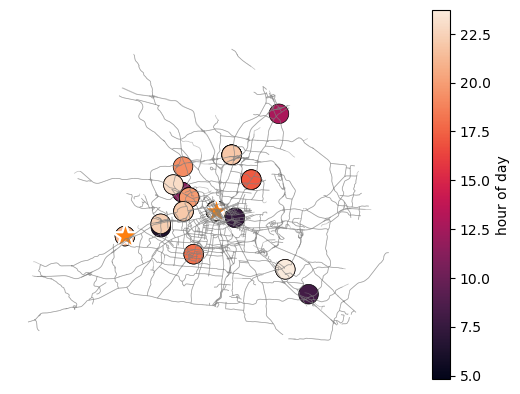

In [79]:
import seaborn as sns
bus_id = 41
ax = sns.scatterplot(data=df.query("bus_id == @bus_id and action == 'dispatch'"), x='src_lon', y='src_lat', hue='timer', 
                     palette='rocket', s=200, 
                     edgecolor="black",
                     linewidth=0.5)
sns.scatterplot(ax=ax, data=df.query("bus_id == @bus_id and action == 'allocate'"), x='src_lon', y='src_lat', marker='*', s=400)

# for k, v in df.query("bus_id == @bus_id").iterrows():
#     spt = v.source_geom
#     ls = LineString([v.source_geom, v.dest_geom])
#     ax.plot(*ls.coords.xy, color='blue', linewidth=0.5, alpha=0.5)
    
norm = plt.Normalize(df['timer'].min(), df['timer'].max())

sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)
inrix_grouped.plot(ax=ax, linewidth=0.5, alpha=0.5, color='gray')
ax.get_legend().remove()
plt.axis('off')
cbar = plt.colorbar(sm)
cbar.set_label('hour of day')
# ax.figure.colorbar(sm)
# fp = 'plots/stationing_locations_norealloc.png'
# plt.savefig(fp, format='png', bbox_inches='tight')